In [188]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.sequence as seq
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Sequence Labelling 

Many real-world applications can be cast as *sequence labelling* problems that involve assigning labels to each element in a sequence. For example, in *Part-Of-Speech tagging* each token in a sentence as assigned a part-of-speech such as verb or determiner that indicates the syntactic type of the token. In *Named Entity Tagging* we assign each token with the type of entity the token refers to, such as "Person" or "Organisation", or "None" if the token does not refer to an entity.  

## Sequence Labelling as Structured Prediction

The problem of sequence labelling is an obvious (and somewhat canonical) instance of structured prediction. Here the input space \\(\Xs\\) are sequences of words and the output space $\Ys$ are sequences of output labels. Our goal is again to define a model a model \\(s_{\params}(\x,\y)\\) that assigns high *scores* to the sequence of label \\(\y=y_1 \ldots y_n\\) that fits the input text \\(\x=x_1 \ldots x_n\\), and lower scores otherwise. The model will be parametrized by \\(\params\\), and these parameters we will learn from some training set \\(\train\\) of \\((\x,\y)\\) pairs. In contrast to the classification scenario the prediction problem $\argmax_\y s_{\params}(\x,\y)$ is now non-trivial in general, as we have to search through an exponentional number of label sequences. In practice this issue is overcome by making assumptions about the factorization structure of $s_{\params}(\x,\y)$ and/or search approximations that sacrifice the ability to find the true optimum of the search problem for more expressiveness. 

## Part-of-Speech Tagging as Sequence Labelling
Part-of-Speech (PoS) tagging is an important task within NLP. It is a standard pre-processing step in many tasks. For example, most dependency parsers assume as input PoS tagged sentences. Likewise, [Reverb](reverb), one of the most effective relation extraction methods, defines relations in terms of PoS sequences.

Traditionally, and based on the existence of corresponding annotated training sets, PoS tagging has been applied to quite restricted domains such newswire or biomedical texts. Recently there has been increasing interest in NLP in general, and PoS tagging in particular, for social media data. He we will focus on PoS tagging for tweets and use the [Tweebank dataset](http://www.cs.cmu.edu/~ark/TweetNLP/#pos) and the ["october 27" splits](https://github.com/brendano/ark-tweet-nlp/tree/master/data/twpos-data-v0.3/oct27.splits).

Let us load the data and look at an example tagged sentence.

In [215]:
train = seq.load_tweebank("../data/oct27.splits/oct27.train")
dev = seq.load_tweebank("../data/oct27.splits/oct27.dev")
test = seq.load_tweebank("../data/oct27.splits/oct27.test")
" ".join([w + "/" + t for w,t in zip(train[0][0],train[0][1])])

"I/O predict/V I/O won't/V win/V a/D single/A game/N I/O bet/V on/P ./, Got/V Cliff/^ Lee/^ today/N ,/, so/P if/P he/O loses/V its/L on/P me/O RT/~ @e_one/@ :/~ Texas/^ (/, cont/~ )/, http://tl.gd/6meogh/U"

We have printed the tokens of tweet paired with their PoS tag. The tags (such as "O", "V" and "^") are described in the [Tweebank annotation guideline](http://www.cs.cmu.edu/~ark/TweetNLP/annot_guidelines.pdf). For example, "O" denotes pronouns, "V" verbs and "^" proper nouns. 

In [190]:
# count tags here?

## Local Models / Classifiers
We will tackle sequence labelling as a (discriminative) structured prediction problem. This means we will build a model $p_\params(\y|\x)$ that computes the conditional probability of output label sequence $\y$ given input sequence $\x$. We will first consider the simplest type of model: a *fully factorised* or *local* model. In this model the probability of $\x$ and $\y$ is a product of *local* probabilities for the label $y_i$ of each token:

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i)
$$

In this model all labels are independent of each other. This assumption has a crucial benefit: inference (and hence training) in this model is trivial. To find the most likely assignment of labels under this model you can find the most likely tag for each token independently. Notice that each local term conditions on the complete input $\x$, not just on $x_i$. This is important, as the sentential context at position $i$ is often important to determine the tag at $i$.     

It is common to indicate this independence structure in a factor graph, a graphical representation of the model. In this representation each variable of the model (our per-token tag labels and the input sequence $\x$) is drawn using a circle, and *observed* variables are shaded. Each factor in the model (terms in the product) is drawn as a box that connects the variables that appear in the corresponding term. For example, the term $p_\params(y_3|\x,3)$ would connect the variables $y_3$ and $\x$. 

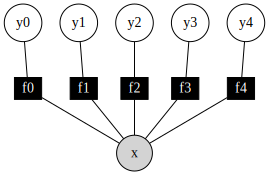

In [191]:
seq.draw_local_fg(5)

The independence assumptions of this model allow us to think of it not as a single sequence model, but a sequence of classification models. We have a classifier $p_\params(y|\x,i)$ that predicts the best class/tag for a token based on its sentence $\x$ and position $i$.

$$
  p_\params(y|\x,i) = \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$

In [235]:
def feat_1(x,i):
    return {
        'word':x[i]
    }


local_1 = seq.LocalSequenceLabeler(feat_1, train)
seq.accuracy(dev, local_1.predict(dev))

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0.6680489321998756

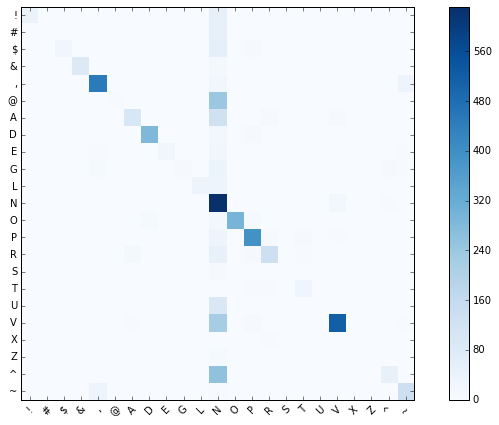

In [249]:
seq.plot_confusion_matrix(dev, local_1.predict(dev))

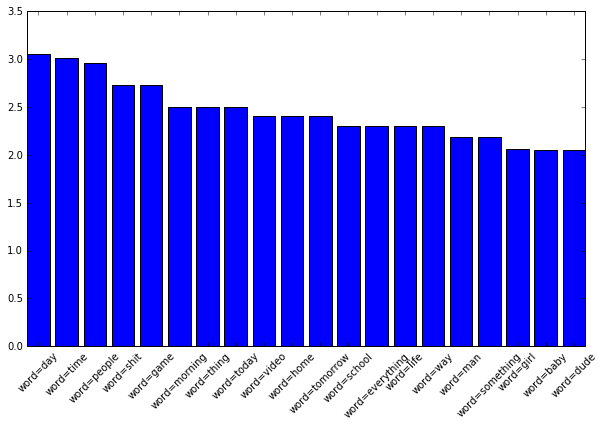

In [236]:
local_1.plot_lr_weights('N')

Find errors on dev set, develop more features based on it. 

In [229]:
local_1.show_errors(dev[:1])  

---------
Gold:  @
Guess: N
 [@ciaranyree] it was on football
{'word': '@ciaranyree'}
---------
Gold:  V
Guess: N
the players and his wife [own] smash burger
{'word': 'own'}
---------
Gold:  ^
Guess: N
players and his wife own [smash] burger
{'word': 'smash'}
---------
Gold:  ^
Guess: N
and his wife own smash [burger] 
{'word': 'burger'}


In [239]:
def feat_2(x,i):
    return {
        'word':x[i],
        'first_at':x[i][0:1] == '@'
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train)
seq.accuracy(dev, local_2.predict(dev))

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0.7173958117354344

In [234]:
# run model with new features
# print results
# show errors
local_2.show_errors(dev[:1])  

---------
Gold:  V
Guess: N
the players and his wife [own] smash burger
{'first_at': False, 'word': 'own'}
---------
Gold:  ^
Guess: N
players and his wife own [smash] burger
{'first_at': False, 'word': 'smash'}
---------
Gold:  ^
Guess: N
and his wife own smash [burger] 
{'first_at': False, 'word': 'burger'}


/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


## MEMM 

In [ ]:
seq.draw_mm_fg(5)

### Viterbi 


## CRF

## Background Material
* [Tackling the Poor Assumptions of Naive Bayes Text Classifiers](https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf), Rennie et al, ICML 2003 
* [Simple Sentiment Classification](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) ???